# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_180  A0A0B4J2B5;S4R460        22.017
Sample_089  P07093-2;P07093-3        13.313
Sample_157  P52848                   14.181
Sample_179  F5GZK2;Q96P44;Q96P44-3   14.479
Sample_122  P08670                   14.351
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                                
Sample_108  F5GWE5;I3L2X8;I3L3W1;I3L459;I3L471;I3L4C0;I3L4H1;I3L4U7;Q00169   11.934
Sample_010  O60565                                                           14.301
Sample_135  Q7Z794                                                           15.418
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.928
            A0A075B6Q5                 11.593
            A0A075B6R2                 12.544
            A0A075B6S5                 12.770
            A0A087WSY4                 12.095
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.755
            Q9UI40;Q9UI40-2            12.334
            Q9UIW2                     12.454
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.875
            Q9UP79                     11.137
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.183,15.050,16.842,19.863,15.641,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.416,19.067,...,15.528,15.576,14.418,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.600,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.962,17.705,17.039,16.329,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.308,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.322,15.345,17.084,18.708,14.249,19.433,12.093,11.504
Sample_207,15.739,16.877,15.469,16.898,14.881,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.928,...,16.012,15.178,13.988,15.050,16.842,19.863,12.928,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.520,19.067,16.188,...,15.528,15.576,13.638,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.565,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.147,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.831,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.878,15.345,17.084,18.708,14.249,19.433,12.479,12.306
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 359.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.77it/s]

100%|██████████| 3/3 [00:00<00:00,  4.40it/s]

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

100%|██████████| 4/4 [00:00<00:00,  3.97it/s]

100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.02it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.52it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.22it/s]

100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.41it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.06it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.54it/s]

100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.63it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.65it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.16it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.08it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.12it/s]

100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.31it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.47it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.97it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.82it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.77it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.76it/s]

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.08it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.86it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.63it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.33it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.41it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.48it/s]

100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.99it/s]

 30%|███       | 3/10 [00:00<00:01,  4.68it/s]

 40%|████      | 4/10 [00:00<00:01,  3.87it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.62it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.02it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.84it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.69it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.67it/s]

100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

100%|██████████| 10/10 [00:03<00:00,  3.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.05it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.88it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.82it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.81it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.66it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.48it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.46it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.59it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.54it/s]

100%|██████████| 11/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.83it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.45it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.11it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.94it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.95it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.81it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.75it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.81it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.85it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.83it/s]

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

100%|██████████| 12/12 [00:04<00:00,  2.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.54it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.77it/s]

 31%|███       | 4/13 [00:01<00:02,  3.58it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.30it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.25it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.15it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.91it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.82it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.83it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.81it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.99it/s]

100%|██████████| 13/13 [00:04<00:00,  3.09it/s]

100%|██████████| 13/13 [00:04<00:00,  3.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.07it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.49it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.28it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.29it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.14it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.00it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.91it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.00it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.07it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.82it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.68it/s]

100%|██████████| 14/14 [00:04<00:00,  2.45it/s]

100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.24it/s]

 20%|██        | 3/15 [00:00<00:03,  3.19it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.71it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.65it/s]

 40%|████      | 6/15 [00:02<00:03,  2.65it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.85it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.96it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.96it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.92it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.98it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.02it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.10it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.17it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.051 0.015          0.756 0.355       0.113   
2             0.004 0.000      0.049 0.006          0.703 0.103       0.616   
3             0.004 0.001      0.049 0.007          0.741 0.099       0.705   
4             0.004 0.002      0.049 0.005          0.807 0.075       0.733   
5             0.008 0.008      0.084 0.027          0.822 0.088       0.756   
6             0.006 0.006      0.075 0.033          0.844 0.080       0.797   
7             0.005 0.005      0.062 0.019          0.844 0.079       0.797   
8             0.005 0.004      0.064 0.023          0.826 0.079       0.785   
9             0.005 0.004      0.056 0.018          0.811 0.083       0.838   
10            0.004 0.001      0.050 0.017          0.810 0.081       0.832   
11            0.004 0.002      0.043 0.009          0.800 0.087       0.832   
12            0.004 0.000      0.047 0.008          0.803 0.079       0.831   
13            0.006 0.005      0.076 0.034          0.790 0.080       0.833   
14            0.006 0.005      0.071 0.025          0.791 0.082       0.832   
15            0.006 0.005      0.080 0.033          0.800 0.080       0.802   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.190 0.128                  0.549 0.041        0.851   
2          0.112   0.648 0.079                  0.708 0.058        0.773   
3          0.131   0.715 0.094                  0.760 0.077        0.857   
4          0.105   0.763 0.070                  0.801 0.056        0.896   
5          0.101   0.783 0.072                  0.816 0.058        0.902   
6          0.091   0.816 0.067                  0.843 0.056        0.907   
7          0.090   0.816 0.067                  0.843 0.056        0.904   
8          0.098   0.801 0.069                  0.831 0.057        0.903   
9          0.096   0.820 0.066                  0.846 0.057        0.917   
10         0.096   0.817 0.065                  0.843 0.056        0.914   
11         0.098   0.811 0.067                  0.838 0.058        0.912   
12         0.097   0.812 0.064                  0.840 0.055        0.911   
13         0.108   0.808 0.080                  0.835 0.068        0.914   
14         0.110   0.808 0.081                  0.835 0.069        0.913   
15         0.100   0.798 0.072                  0.827 0.061        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.069                  0.717 0.093        210.000 0.000  
3          0.057                  0.819 0.074        210.000 0.000  
4          0.048                  0.877 0.058        210.000 0.000  
5          0.048                  0.887 0.059        210.000 0.000  
6          0.049                  0.895 0.055        210.000 0.000  
7          0.051                  0.893 0.056        210.000 0.000  
8          0.051                  0.893 0.055        210.000 0.000  
9          0.046                  0.913 0.044        210.000 0.000  
10         0.048                  0.909 0.048        210.000 0.000  
11         0.049                  0.905 0.049        210.000 0.000  
12         0.050                  0.906 0.049        210.000 0.000  
13         0.045                  0.904 0.046        210.000 0.000  
14         0.044                  0.903 0.046        210.000 0.000  
15         0.044                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 472.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.75it/s]

100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.99it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.42it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.86it/s]

100%|██████████| 5/5 [00:01<00:00,  2.47it/s]

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.68it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.04it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.15it/s]

100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.43it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.64it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.67it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.63it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.51it/s]

100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.70it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.55it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.15it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.18it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.66it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.41it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.51it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.19it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.23it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.26it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.98it/s]

100%|██████████| 9/9 [00:03<00:00,  2.01it/s]

100%|██████████| 9/9 [00:03<00:00,  2.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.42it/s]

 30%|███       | 3/10 [00:00<00:01,  3.90it/s]

 40%|████      | 4/10 [00:01<00:02,  2.67it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.26it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.80it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.68it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.65it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.70it/s]

100%|██████████| 10/10 [00:04<00:00,  1.86it/s]

100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.13it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.26it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.85it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.64it/s]

 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.71it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.84it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.89it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.98it/s]

100%|██████████| 11/11 [00:05<00:00,  2.04it/s]

100%|██████████| 11/11 [00:05<00:00,  1.94it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.34it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.62it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.53it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.39it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.09it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.90it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.08it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.13it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.15it/s]

100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

100%|██████████| 12/12 [00:05<00:00,  2.24it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.27it/s]

 31%|███       | 4/13 [00:01<00:03,  2.93it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.72it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.63it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.48it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.17it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.03it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.03it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.05it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.21it/s]

100%|██████████| 13/13 [00:05<00:00,  2.33it/s]

100%|██████████| 13/13 [00:05<00:00,  2.41it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.02it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.56it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.09it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.86it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.70it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.62it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.58it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.69it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.53it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.22it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.04it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.86it/s]

100%|██████████| 14/14 [00:05<00:00,  1.92it/s]

100%|██████████| 14/14 [00:05<00:00,  2.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.97it/s]

 20%|██        | 3/15 [00:01<00:04,  2.43it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.27it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.28it/s]

 40%|████      | 6/15 [00:02<00:03,  2.39it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.48it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.54it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.66it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.69it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.73it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.04it/s]

100%|██████████| 15/15 [00:06<00:00,  1.79it/s]

100%|██████████| 15/15 [00:06<00:00,  2.29it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.065 0.023          0.000 0.000       0.000   
2             0.007 0.008      0.075 0.029          0.778 0.091       0.672   
3             0.005 0.004      0.068 0.031          0.770 0.109       0.703   
4             0.005 0.003      0.058 0.017          0.745 0.115       0.704   
5             0.005 0.004      0.055 0.019          0.768 0.112       0.713   
6             0.004 0.003      0.051 0.017          0.795 0.087       0.763   
7             0.005 0.004      0.060 0.021          0.794 0.086       0.769   
8             0.005 0.004      0.072 0.030          0.788 0.087       0.763   
9             0.005 0.004      0.068 0.028          0.760 0.093       0.756   
10            0.006 0.006      0.063 0.025          0.813 0.096       0.785   
11            0.005 0.004      0.058 0.018          0.798 0.096       0.805   
12            0.004 0.002      0.059 0.018          0.796 0.096       0.807   
13            0.006 0.005      0.066 0.029          0.812 0.084       0.823   
14            0.005 0.004      0.068 0.028          0.839 0.079       0.844   
15            0.007 0.006      0.077 0.033          0.842 0.078       0.833   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.850   
2          0.104   0.716 0.077                  0.764 0.058        0.810   
3          0.102   0.728 0.078                  0.771 0.063        0.845   
4          0.098   0.717 0.077                  0.759 0.066        0.840   
5          0.109   0.732 0.084                  0.773 0.068        0.845   
6          0.115   0.773 0.075                  0.807 0.062        0.889   
7          0.119   0.775 0.077                  0.810 0.062        0.889   
8          0.122   0.770 0.083                  0.805 0.068        0.888   
9          0.112   0.753 0.083                  0.789 0.068        0.892   
10         0.116   0.792 0.078                  0.823 0.064        0.916   
11         0.117   0.796 0.084                  0.826 0.070        0.918   
12         0.121   0.796 0.086                  0.826 0.072        0.917   
13         0.115   0.812 0.075                  0.841 0.064        0.922   
14         0.096   0.837 0.069                  0.861 0.059        0.934   
15         0.094   0.834 0.066                  0.858 0.055        0.936   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.088        210.000 0.000  
2          0.064                  0.761 0.093        210.000 0.000  
3          0.055                  0.804 0.078        210.000 0.000  
4          0.057                  0.791 0.082        210.000 0.000  
5          0.057                  0.795 0.082        210.000 0.000  
6          0.042                  0.858 0.058        210.000 0.000  
7          0.042                  0.857 0.058        210.000 0.000  
8          0.043                  0.854 0.059        210.000 0.000  
9          0.047                  0.864 0.058        210.000 0.000  
10         0.042                  0.889 0.059        210.000 0.000  
11         0.044                  0.894 0.058        210.000 0.000  
12         0.044                  0.893 0.058        210.000 0.000  
13         0.041                  0.894 0.059        210.000 0.000  
14         0.037                  0.915 0.049        210.000 0.000  
15         0.035                  0.918 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 845.11it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.31it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.11it/s]

100%|██████████| 3/3 [00:00<00:00, 16.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 13.78it/s]

100%|██████████| 4/4 [00:00<00:00, 13.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.10it/s]

100%|██████████| 5/5 [00:00<00:00, 11.54it/s]

100%|██████████| 5/5 [00:00<00:00, 11.85it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.21it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 14.69it/s]

100%|██████████| 6/6 [00:00<00:00, 12.41it/s]

100%|██████████| 6/6 [00:00<00:00, 12.98it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.72it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 16.57it/s]

100%|██████████| 7/7 [00:00<00:00, 13.83it/s]

100%|██████████| 7/7 [00:00<00:00, 14.73it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.93it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.13it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.07it/s]

100%|██████████| 8/8 [00:00<00:00, 13.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.81it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 13.79it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.51it/s]

100%|██████████| 9/9 [00:00<00:00, 12.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 14.56it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.46it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.80it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.88it/s]

100%|██████████| 10/10 [00:01<00:00,  8.98it/s]

100%|██████████| 10/10 [00:01<00:00,  9.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 14.03it/s]

 45%|████▌     | 5/11 [00:00<00:00, 10.47it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  9.04it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.23it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  8.23it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.42it/s]

100%|██████████| 11/11 [00:01<00:00,  8.66it/s]

100%|██████████| 11/11 [00:01<00:00,  8.90it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.36it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.58it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.20it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.66it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 14.04it/s]

100%|██████████| 12/12 [00:00<00:00, 14.21it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.80it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.16it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.87it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.81it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.09it/s]

100%|██████████| 13/13 [00:01<00:00, 11.80it/s]

100%|██████████| 13/13 [00:01<00:00, 12.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.65it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.86it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.68it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.22it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.17it/s]

100%|██████████| 14/14 [00:01<00:00, 12.78it/s]

100%|██████████| 14/14 [00:01<00:00, 13.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.01it/s]

 33%|███▎      | 5/15 [00:00<00:00, 12.16it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.20it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.47it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.33it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.66it/s]

100%|██████████| 15/15 [00:01<00:00, 11.50it/s]

100%|██████████| 15/15 [00:01<00:00, 11.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.055 0.019          0.000 0.000       0.000   
2             0.006 0.004      0.067 0.025          0.689 0.129       0.449   
3             0.005 0.005      0.075 0.032          0.690 0.135       0.436   
4             0.005 0.003      0.052 0.017          0.679 0.131       0.437   
5             0.006 0.006      0.078 0.029          0.684 0.127       0.431   
6             0.005 0.006      0.054 0.013          0.699 0.112       0.476   
7             0.004 0.002      0.060 0.023          0.700 0.116       0.473   
8             0.004 0.002      0.048 0.013          0.684 0.111       0.565   
9             0.005 0.005      0.067 0.033          0.720 0.091       0.593   
10            0.004 0.000      0.049 0.006          0.725 0.089       0.649   
11            0.005 0.004      0.062 0.023          0.713 0.093       0.651   
12            0.004 0.002      0.061 0.022          0.706 0.089       0.643   
13            0.005 0.003      0.060 0.024          0.696 0.086       0.630   
14            0.007 0.005      0.070 0.025          0.692 0.092       0.620   
15            0.005 0.003      0.052 0.022          0.691 0.092       0.625   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.724   
2          0.087   0.538 0.086                  0.647 0.061        0.729   
3          0.121   0.524 0.109                  0.643 0.064        0.749   
4          0.121   0.522 0.108                  0.640 0.063        0.745   
5          0.125   0.517 0.104                  0.639 0.062        0.740   
6          0.111   0.557 0.087                  0.660 0.056        0.728   
7          0.120   0.554 0.098                  0.659 0.062        0.725   
8          0.120   0.611 0.096                  0.684 0.069        0.764   
9          0.106   0.642 0.072                  0.709 0.051        0.781   
10         0.119   0.677 0.078                  0.732 0.062        0.786   
11         0.118   0.673 0.084                  0.727 0.066        0.800   
12         0.119   0.666 0.081                  0.721 0.063        0.797   
13         0.119   0.654 0.082                  0.712 0.061        0.793   
14         0.115   0.647 0.080                  0.707 0.064        0.793   
15         0.120   0.649 0.083                  0.708 0.065        0.793   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.681 0.089        210.000 0.000  
2          0.070                  0.658 0.090        210.000 0.000  
3          0.073                  0.679 0.089        210.000 0.000  
4          0.075                  0.669 0.094        210.000 0.000  
5          0.079                  0.660 0.097        210.000 0.000  
6          0.074                  0.659 0.095        210.000 0.000  
7          0.076                  0.656 0.095        210.000 0.000  
8          0.068                  0.727 0.082        210.000 0.000  
9          0.060                  0.742 0.080        210.000 0.000  
10         0.064                  0.744 0.086        210.000 0.000  
11         0.069                  0.753 0.092        210.000 0.000  
12         0.069                  0.749 0.092        210.000 0.000  
13         0.065                  0.747 0.089        210.000 0.000  
14         0.065                  0.748 0.085        210.000 0.000  
15         0.065                  0.746 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,2,14
score_time,5,15,5
test_precision,6,15,10
test_recall,9,14,11
test_f1,9,14,10
test_balanced_accuracy,9,14,10
test_roc_auc,15,15,11
test_average_precision,9,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.69it/s]

 20%|██        | 3/15 [00:01<00:04,  2.75it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.31it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.28it/s]

 40%|████      | 6/15 [00:02<00:03,  2.30it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.33it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.37it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.36it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.35it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.31it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.24it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.23it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.20it/s]

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.75it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.94it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.59it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.31it/s]

100%|██████████| 11/11 [00:00<00:00, 12.21it/s]

100%|██████████| 11/11 [00:00<00:00, 12.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.49it/s]

 20%|██        | 3/15 [00:00<00:03,  3.66it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.63it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.23it/s]

 40%|████      | 6/15 [00:02<00:04,  2.14it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.10it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.31it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.46it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.47it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.50it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.53it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.61it/s]

100%|██████████| 15/15 [00:06<00:00,  2.33it/s]

100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


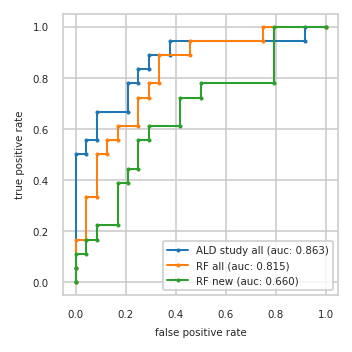

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.167  0.000 0.111
3          0.042 0.500  0.042 0.167  0.042 0.111
4          0.042 0.556  0.042 0.333  0.042 0.167
5          0.083 0.556  0.083 0.333  0.083 0.167
6          0.083 0.667  0.083 0.500  0.083 0.222
7          0.208 0.667  0.125 0.500  0.167 0.222
8          0.208 0.778  0.125 0.556  0.167 0.389
9          0.250 0.778  0.167 0.556  0.208 0.389
10         0.250 0.833  0.167 0.611  0.208 0.444
11         0.292 0.833  0.250 0.611  0.250 0.444
12         0.292 0.889  0.250 0.722  0.250 0.556
13         0.375 0.889  0.292 0.722  0.292 0.556
14         0.375 0.944  0.292 0.778  0.292 0.611
15         0.917 0.944  0.333 0.778  0.417 0.611
16         0.917 1.000  0.333 0.889  0.417 0.722
17         1.000 1.000  0.458 0.889  0.500 0.722
18           NaN   NaN  0.458 0.944  0.500 0.778
19           NaN   NaN  0.750 0.944  0.792 0.778
20           NaN   NaN  0.750 1.000  0.792 1.000
21           NaN   NaN  1.000 1.000  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,F6VDH7;P50502;Q3KNR6,P09382,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
2,Q92743,C9JIZ6;P07602;P07602-2;P07602-3,P51688
3,P04075,F8WE04;P04792,Q96GD0
4,P61981,P10636-2;P10636-6,J3KSJ8;Q9UD71;Q9UD71-2
5,P14174,P04075,P31321
6,A0A0C4DGY8;D6RA00;Q9UHY7,P14174,P31150
7,P05413;S4R371,Q14894,A0A075B7B8
8,P08294,P61981,Q504Y2


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


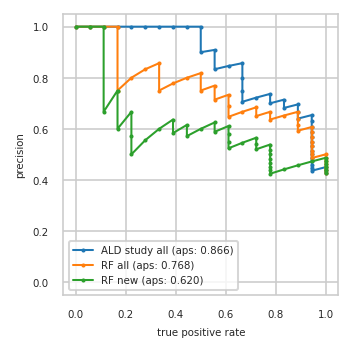

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.486 0.944     0.457 0.889
8          0.500 0.944     0.500 0.944     0.441 0.833
9          0.515 0.944     0.515 0.944     0.424 0.778
10         0.531 0.944     0.531 0.944     0.438 0.778
11         0.548 0.944     0.548 0.944     0.452 0.778
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.750 0.667     0.688 0.611     0.625 0.556
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.846 0.611     0.769 0.556     0.615 0.444
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.750 0.333     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


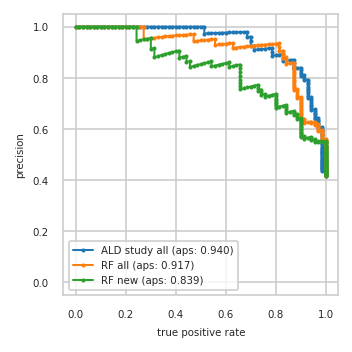

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


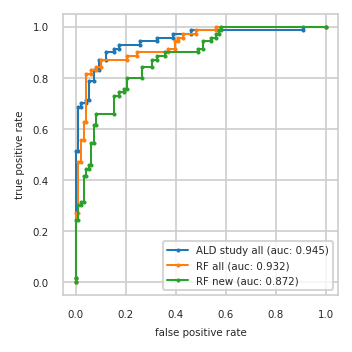

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}